In [1]:
import os
import re
import argparse
import math
import torch
import pickle
import warnings
import random
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from braceexpand import braceexpand
from tqdm import tqdm
import multiprocessing as mp
from copy import copy
from scipy.sparse import csr_matrix
from datetime import datetime

# for flex attention
import torch._dynamo
import torch.multiprocessing as mp 
torch._dynamo.config.suppress_errors = True

sc.set_figure_params(figsize=(4, 4))

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext, \
    GeneNetworkAnalysisBase

2025-03-26 21:06:21.955000: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 21:06:23.326084: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
ROOT_PATH = "/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm"

ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/pbmc_adata.h5ad'
REF_ADATA_FP = '/work/hdd/bbjr/mallina1/data/mb-ml-dev-vm/data/extract_0.h5ad'
OUT_ADATA_DIR = '/work/hdd/bbjr/mallina1/data/human_cellariumgpt_v2/assay_conversion'

GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")
CHECKPOINT_PATH = "/work/hdd/bbjr/mallina1/cellarium/models/compute_optimal_checkpoints/epoch=6-step=63560.ckpt"
DEVICE = 'cuda'

assay_label_map = {
    "10x Chromium (v2) A": "10x 3' v2",
    "10x Chromium (v2) B": "10x 3' v2",
    "10x Chromium (v3)": "10x 3' v3",
    "Drop-seq": "Drop-seq",
    "Seq-Well": "Seq-Well",
    "inDrops": "inDrop"
}

assay_ontology_term_id_map = {
    "Seq-Well": "EFO:0008919",
    "10x 3' v3": "EFO:0009922",
    "Drop-seq": "EFO:0008722",
    "inDrop": "EFO:0008780",
    "10x 3' v2": "EFO:0009899"
}

methods = list(assay_label_map.keys())

In [3]:
ref_adata = sc.read_h5ad(REF_ADATA_FP)
val_adata = sc.read_h5ad(ADATA_FP)

# Obtain Cellarium var_names for subsampling later as well
ref_var_names = set(ref_adata.var_names)

# First subset the validation gene counts to those that show up in Cellarium training
val_adata = val_adata[:, val_adata.var_names.isin(ref_var_names)]

# Next subset by assays that we have relevant data for in Cellarium based on the assay_label_map
val_adata = val_adata[val_adata.obs.Method.isin(list(assay_label_map.keys()))]

In [4]:
val_adata

View of AnnData object with n_obs × n_vars = 26607 × 32351
    obs: 'NAME', 'nGene', 'nUMI', 'percent.mito', 'Cluster', 'CellType', 'Experiment', 'Method'
    var: 'gene_symbols'
    uns: 'CellType_colors', 'Method_colors'
    obsm: 'X_harmony'

In [5]:
val_adata = val_adata[val_adata.obs.Method == '10x Chromium (v3)']
val_adata = val_adata[val_adata.obs.CellType == 'CD4+ T cell']

In [6]:
# from copy import copy
# orig_X = copy(val_adata.X)

# n=10

# var_names = list(set(val_adata.var_names))
# sample_idx = random.sample(range(len(var_names)), n)
# sample_idx.sort()
# fixed_genes = [var_names[i] for i in sample_idx]

# adata1 = val_adata[:, val_adata.var_names.isin(fixed_genes)]
# adata2 = val_adata[:, np.array(fixed_genes)]

In [7]:
# print(adata1.X)
# print(adata2.X)

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_FP,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient"
)
# ctx.metadata_ontology_infos['cell_type']['labels']

In [8]:
# pre-process val_adata for conversion
processed_val_adata = val_adata.copy()

# Get random values for cell_type, tissue, disease, sex, and development_stage from ref_adata
# since we are going to mask all of this anyway, just needed to have a valid category in the
# get_tokens_from_adata function.

cell_type_ontology_term_id = [ctx.metadata_ontology_infos['cell_type']['names'][-1]] * val_adata.shape[0]
tissue_ontology_term_id = [ctx.metadata_ontology_infos['tissue']['names'][-1]] * val_adata.shape[0]
disease_ontology_term_id = [ctx.metadata_ontology_infos['disease']['names'][-1]] * val_adata.shape[0]
sex_ontology_term_id = [ctx.metadata_ontology_infos['sex']['names'][-1]] * val_adata.shape[0]
development_stage_ontology_term_id = [ctx.metadata_ontology_infos['development_stage']['names'][-1]] * val_adata.shape[0]

processed_val_adata.obs['assay'] = val_adata.obs['Method'].map(assay_label_map)
processed_val_adata.obs['assay_ontology_term_id'] = processed_val_adata.obs['assay'].map(assay_ontology_term_id_map)
processed_val_adata.obs['suspension_type'] = 'cell'
processed_val_adata.obs['total_mrna_umis'] = processed_val_adata.obs.nUMI.astype(np.int64)

# assay = []
# suspension_type = []
# assay_ontology_term_id = []
# total_mrna_umis = []
# for val_obs_idx in tqdm(range(val_adata.shape[0])):
#     val_obs_row = val_adata.obs.iloc[val_obs_idx]
    
#     # PBMC adata fields
#     pbmc_method = val_obs_row.Method

#     # (converted) cellarium adata fields
#     suspension_type.append('cell')
#     assay.append(assay_label_map[pbmc_method])
#     assay_ontology_term_id.append(assay_ontology_term_id_map[assay_label_map[pbmc_method]])
#     total_mrna_umis.append(val_obs_row.nUMI)

# processed_val_adata.obs['assay'] = assay
# processed_val_adata.obs['suspension_type'] = suspension_type
# processed_val_adata.obs['assay_ontology_term_id'] = assay_ontology_term_id
# processed_val_adata.obs['total_mrna_umis'] = np.array(total_mrna_umis, dtype=np.int64)

processed_val_adata.obs['cell_type_ontology_term_id'] = cell_type_ontology_term_id
processed_val_adata.obs['tissue_ontology_term_id'] = tissue_ontology_term_id
processed_val_adata.obs['disease_ontology_term_id'] = disease_ontology_term_id
processed_val_adata.obs['sex_ontology_term_id'] = sex_ontology_term_id
processed_val_adata.obs['development_stage_ontology_term_id'] = development_stage_ontology_term_id

In [9]:
processed_val_adata.obs

,NAME,nGene,nUMI,percent.mito,Cluster,CellType,Experiment,Method,assay,assay_ontology_term_id,suspension_type,total_mrna_umis,cell_type_ontology_term_id,tissue_ontology_term_id,disease_ontology_term_id,sex_ontology_term_id,development_stage_ontology_term_id
6697,pbmc1_10x_v3_AAACCCACACTTGGGC,1860,6914,0.0911194677466011,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,6914,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
6698,pbmc1_10x_v3_AAACCCATCTTACACT,1758,6168,0.0856031128404669,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,6168,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
6699,pbmc1_10x_v3_AAAGAACAGCAGGCAT,2425,8265,0.0815486993345433,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,8265,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
6700,pbmc1_10x_v3_AAAGAACTCAAAGACA,1553,5789,0.0730696147866644,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,5789,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
6701,pbmc1_10x_v3_AAAGTCCGTAGGCAGT,2655,9163,0.0966932227436429,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,9163,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9885,pbmc1_10x_v3_TTCATGTAGAGGTGCT,1065,3376,0.0832345971563981,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,3376,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
9887,pbmc1_10x_v3_TTCGCTGCAACTGGTT,1489,4289,0.15178363254838,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,4289,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
9888,pbmc1_10x_v3_TTGGGATTCATGAGAA,1377,4521,0.100420261004203,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,4521,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260
9889,pbmc1_10x_v3_TTTCACAAGGTACTGG,1570,5749,0.12645677509132,1,CD4+ T cell,pbmc1,10x Chromium (v3),10x 3' v3,EFO:0009922,cell,5749,CL:4033058,UBERON:8480028,MONDO:0600025,PATO:0000383,HsapDv:0000260


In [10]:
pd.crosstab(processed_val_adata.obs['assay'], processed_val_adata.obs['Method'])

Method,10x Chromium (v3)
assay,
10x 3' v3,960


In [11]:
# ctx = CellariumGPTInferenceContext(
#     cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
#     ref_adata_path=REF_ADATA_FP,
#     gene_info_tsv_path=GENE_INFO_PATH,
#     device=DEVICE,
#     attention_backend="mem_efficient"
# )

## Unbatched

In [12]:
# rng = torch.Generator(device='cpu')

# metadata_prompt_dict = {
#     "cell_type": False,
#     "tissue": False,
#     "disease": False,
#     "sex": False,
#     "development_stage": False
# }

# target_assay = '10x Chromium (v3)'
# n_fixed_query_genes = 4096

# var_names = list(set(processed_val_adata.var_names))

# sample_indices = random.sample(range(len(var_names)), n_fixed_query_genes)
# sample_indices.sort()
# fixed_query_genes = [var_names[i] for i in sample_indices]  
# # fixed_query_genes = np.random.choice(var_names, size=n_fixed_query_genes, replace=False)

# # adata_fixed_genes_original = processed_val_adata[:, processed_val_adata.var_names.isin(fixed_query_genes)].copy()
# adata_fixed_genes_original = processed_val_adata[:, np.array(fixed_query_genes)]
# adata_fixed_genes_converted = adata_fixed_genes_original.copy()

# skipped_row = []
# X_lil = adata_fixed_genes_converted.X.tolil()
# for val_obs_idx in tqdm(range(adata_fixed_genes_original.shape[0])):
# # for val_obs_idx in tqdm(range(10)):
#     pbmc_cell_type = adata_fixed_genes_original.obs.iloc[val_obs_idx].CellType

#     # UMIs by cell type and target assay in order to sample from in conversion
#     pbmc_umis = val_adata[val_adata.obs.CellType == pbmc_cell_type]
#     pbmc_umis = pbmc_umis[pbmc_umis.obs.Method == target_assay]

#     # Use the global nUMI in the adata to sample from
#     pbmc_umis = pbmc_umis.obs.nUMI.to_numpy()

#     # Some cell types don't have any data for a given target_assay, skip these and flag it for now
#     if len(pbmc_umis) == 0:
#         skipped_row.append(True)
#         continue

#     # Use the empirical nUMI subset by the random sampled genes in the adata to sample from
#     # pbmc_umis = np.array(pbmc_umis[:, pbmc_umis.var_names.isin(fixed_query_genes)].X.sum(-1)).squeeze()

#     # for all query genes we sample the UMIs based on  subsetting to (cell_type, target_assay)
#     # allow replacement because n_fixed_query_genes might be > len(pbmc_umis) from this dataset
#     query_total_mrna_umis = np.random.choice(pbmc_umis, size=(n_fixed_query_genes,), replace=True)
#     query_total_mrna_umis = np.array(query_total_mrna_umis, dtype=np.int64)[None,:]

#     query_assay = assay_label_map[target_assay]
#     query_assay_ontology_term_id = assay_ontology_term_id_map[query_assay]

#     with torch.no_grad():
#         tokens_dict, context_indices = ctx.generate_tokens_from_adata(processed_val_adata, 
#                                                                     obs_index=[val_obs_idx], 
#                                                                     query_var_names=fixed_query_genes,
#                                                                     metadata_prompt_masks_dict=metadata_prompt_dict,
#                                                                     n_rand_prompt_vars=0,
#                                                                     rand_prompt_var_names_sublist=[],
#                                                                     fixed_prompt_var_names_sublist=fixed_query_genes,
#                                                                     rng = rng,
#                                                                     query_total_mrna_umis=query_total_mrna_umis,
#                                                                     query_assay_ontology_term_id=query_assay_ontology_term_id)
        
#         # tokens_dict, context_indices = ctx.generate_tokens_from_adata(adata_fixed_genes_original, 
#         #                                                             obs_index=[val_obs_idx], 
#         #                                                             query_var_names=fixed_query_genes,
#         #                                                             metadata_prompt_masks_dict=metadata_prompt_dict,
#         #                                                             query_total_mrna_umis=None,
#         #                                                             query_assay_ontology_term_id=None)

#         gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(tokens_dict,
#                                                                 context_indices,
#                                                                 max_counts=None)
#         gene_logits_nqk = gene_logits_nqk.cpu()

#         dist = torch.distributions.categorical.Categorical(logits = gene_logits_nqk.squeeze())
#         row_sample = dist.sample().numpy()
#         # adata_fixed_genes_converted.X[val_obs_idx] = csr_matrix(row_sample)
#         X_lil[val_obs_idx,:] = row_sample
#         skipped_row.append(False)

# adata_fixed_genes_converted.X = X_lil.tocsr()

# adata_fixed_genes_original.obs['skipped_row'] = skipped_row
# adata_fixed_genes_converted.obs['skipped_row'] = skipped_row

## Unbatched - only expressed

In [13]:
processed_val_adata.X[0].nonzero()[1]

array([    2,    20,    22, ..., 31907, 31997, 32004], dtype=int32)

In [14]:
# rng = torch.Generator(device='cpu')

# metadata_prompt_dict = {
#     "cell_type": False,
#     "tissue": False,
#     "disease": False,
#     "sex": False,
#     "development_stage": False
# }

# target_assay = '10x Chromium (v3)'
# n_fixed_query_genes = 4096

# var_names = list(set(processed_val_adata.var_names))


# # sample_indices = random.sample(range(len(var_names)), n_fixed_query_genes)
# # sample_indices.sort()
# # fixed_query_genes = [var_names[i] for i in sample_indices]  
# # fixed_query_genes = np.random.choice(var_names, size=n_fixed_query_genes, replace=False)

# # adata_fixed_genes_original = processed_val_adata[:, processed_val_adata.var_names.isin(fixed_query_genes)].copy()
# # adata_fixed_genes_original = processed_val_adata[:, np.array(fixed_query_genes)]
# # adata_fixed_genes_converted = adata_fixed_genes_original.copy()

# adata_fixed_genes_original = processed_val_adata[:, np.array(var_names)]
# adata_fixed_genes_converted = adata_fixed_genes_original.copy()

# skipped_row = []
# X_lil = adata_fixed_genes_converted.X.tolil()
# for val_obs_idx in tqdm(range(adata_fixed_genes_original.shape[0])):
#     nonzero_idx = adata_fixed_genes_original.X[val_obs_idx].nonzero()[1]
#     fixed_query_genes = [var_names[i] for i in nonzero_idx]

#     # pbmc_cell_type = processed_val_adata.obs.iloc[val_obs_idx].CellType

#     # # UMIs by cell type and target assay in order to sample from in conversion
#     # pbmc_umis = val_adata[val_adata.obs.CellType == pbmc_cell_type]
#     # pbmc_umis = pbmc_umis[pbmc_umis.obs.Method == target_assay]

#     # # Use the global nUMI in the adata to sample from
#     # pbmc_umis = pbmc_umis.obs.nUMI.to_numpy()

#     # # Some cell types don't have any data for a given target_assay, skip these and flag it for now
#     # if len(pbmc_umis) == 0:
#     #     skipped_row.append(True)
#     #     continue

#     # # Use the empirical nUMI subset by the random sampled genes in the adata to sample from
#     # # pbmc_umis = np.array(pbmc_umis[:, pbmc_umis.var_names.isin(fixed_query_genes)].X.sum(-1)).squeeze()

#     # # for all query genes we sample the UMIs based on  subsetting to (cell_type, target_assay)
#     # # allow replacement because n_fixed_query_genes might be > len(pbmc_umis) from this dataset
#     # query_total_mrna_umis = np.random.choice(pbmc_umis, size=(n_fixed_query_genes,), replace=True)
#     # query_total_mrna_umis = np.array(query_total_mrna_umis, dtype=np.int64)[None,:]

#     # query_assay = assay_label_map[target_assay]
#     # query_assay_ontology_term_id = assay_ontology_term_id_map[query_assay]

#     with torch.no_grad():
#         tokens_dict, context_indices = ctx.generate_tokens_from_adata(adata_fixed_genes_original, 
#                                                                     obs_index=[val_obs_idx], 
#                                                                     query_var_names=fixed_query_genes,
#                                                                     metadata_prompt_masks_dict=metadata_prompt_dict,
#                                                                     n_rand_prompt_vars=0,
#                                                                     rand_prompt_var_names_sublist=[],
#                                                                     fixed_prompt_var_names_sublist=fixed_query_genes,
#                                                                     rng = rng,
#                                                                     query_total_mrna_umis=None,
#                                                                     query_assay_ontology_term_id=None)

#         # tokens_dict, context_indices = ctx.generate_tokens_from_adata(adata_fixed_genes_original, 
#         #                                                             obs_index=[val_obs_idx], 
#         #                                                             query_var_names=fixed_query_genes,
#         #                                                             metadata_prompt_masks_dict=metadata_prompt_dict,
#         #                                                             query_total_mrna_umis=None,
#         #                                                             query_assay_ontology_term_id=None)

#         gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(tokens_dict,
#                                                                 context_indices,
#                                                                 max_counts=None)
#         gene_logits_nqk = gene_logits_nqk.cpu()

#         dist = torch.distributions.categorical.Categorical(logits = gene_logits_nqk.squeeze())
#         row_sample = dist.sample().numpy()
#         # adata_fixed_genes_converted.X[val_obs_idx] = csr_matrix(row_sample)
#         for row_sample_idx, X_idx in enumerate(nonzero_idx):
#             X_lil[val_obs_idx, X_idx] = row_sample[row_sample_idx]
#         # X_lil[val_obs_idx,:] = row_sample
#         skipped_row.append(False)

# adata_fixed_genes_converted.X = X_lil.tocsr()

# adata_fixed_genes_original.obs['skipped_row'] = skipped_row
# adata_fixed_genes_converted.obs['skipped_row'] = skipped_row

## Batched

In [15]:
rng = torch.Generator(device='cpu')

metadata_prompt_dict = {
    "cell_type": False,
    "tissue": False,
    "disease": False,
    "sex": False,
    "development_stage": False
}

target_assay = '10x Chromium (v3)' # double check this doesn't get masked
n_fixed_query_genes = 4096

var_names = list(set(processed_val_adata.var_names))

sample_indices = random.sample(range(len(var_names)), n_fixed_query_genes)
sample_indices.sort()
fixed_query_genes = [var_names[i] for i in sample_indices]  
# fixed_query_genes = np.random.choice(var_names, size=n_fixed_query_genes, replace=False)

# processed_val_adata = processed_val_adata[:, np.array(fixed_query_genes)]
# adata_fixed_genes_original = processed_val_adata[:, processed_val_adata.var_names.isin(fixed_query_genes)].copy()
adata_fixed_genes_original = processed_val_adata[:, np.array(fixed_query_genes)]
# adata_fixed_genes_original = processed_val_adata.copy()
adata_fixed_genes_converted = adata_fixed_genes_original.copy()

batch_size = 32
skipped_row = []
X_lil = adata_fixed_genes_converted.X.tolil()

for batch_idx in tqdm(range(0, adata_fixed_genes_original.shape[0], batch_size)):
# for batch_idx in range(1):
    batch_query_total_mrna_umis = []

    obs_idx = []
    for val_obs_idx in range(batch_idx, batch_idx + batch_size):
        if val_obs_idx >= adata_fixed_genes_original.shape[0]:
            continue

        pbmc_cell_type = adata_fixed_genes_original.obs.iloc[val_obs_idx].CellType

        # UMIs by cell type and target assay in order to sample from in conversion
        pbmc_umis = val_adata[val_adata.obs.CellType == pbmc_cell_type]
        pbmc_umis = pbmc_umis[pbmc_umis.obs.Method == target_assay]

        # Use the global nUMI in the adata to sample from
        pbmc_umis = pbmc_umis.obs.nUMI.to_numpy()
        # pbmc_umis = np.array(pbmc_umis[:, pbmc_umis.var_names.isin(fixed_query_genes)].X.sum(-1)).squeeze()

        # Some cell types don't have any data for a given target_assay, skip these and flag it for now
        if len(pbmc_umis) == 0:
            skipped_row.append(True)
            continue

        # Use the empirical nUMI subset by the random sampled genes in the adata to sample from
        # pbmc_umis = np.array(pbmc_umis[:, pbmc_umis.var_names.isin(fixed_query_genes)].X.sum(-1)).squeeze()

        # for all query genes we sample the UMIs based on  subsetting to (cell_type, target_assay)
        # allow replacement because n_fixed_query_genes might be > len(pbmc_umis) from this dataset

        # umi_vals,umi_counts = np.unique(pbmc_umis, return_counts=True)
        # umi_mode_index = np.argmax(umi_counts)
        # query_total_mrna_umis = np.array([[umi_counts[umi_mode_index]] * n_fixed_query_genes])
        # batch_query_total_mrna_umis.append(query_total_mrna_umis)

        query_total_mrna_umis = np.random.choice(pbmc_umis, size=(n_fixed_query_genes,), replace=True)
        query_total_mrna_umis = np.array(query_total_mrna_umis, dtype=np.int64)
        batch_query_total_mrna_umis.append(query_total_mrna_umis[None, :])
        obs_idx.append(val_obs_idx)
        skipped_row.append(False)
    
    batch_query_total_mrna_umis = np.concatenate(batch_query_total_mrna_umis, axis=0)

    query_assay = assay_label_map[target_assay]
    query_assay_ontology_term_id = assay_ontology_term_id_map[query_assay]

    with torch.no_grad():
        # tokens_dict, context_indices = ctx.generate_tokens_from_adata(processed_val_adata, 
        #                                                             obs_index=obs_idx, 
        #                                                             query_var_names=fixed_query_genes,
        #                                                             metadata_prompt_masks_dict=metadata_prompt_dict,
        #                                                             n_rand_prompt_vars=0,
        #                                                             rand_prompt_var_names_sublist=[],
        #                                                             fixed_prompt_var_names_sublist=fixed_query_genes,
        #                                                             rng = rng,
        #                                                             query_total_mrna_umis=batch_query_total_mrna_umis,
        #                                                             query_assay_ontology_term_id=query_assay_ontology_term_id)
        
        tokens_dict, context_indices = ctx.generate_tokens_from_adata(adata_fixed_genes_original, 
                                                                    obs_index=obs_idx, 
                                                                    query_var_names=fixed_query_genes,
                                                                    metadata_prompt_masks_dict=metadata_prompt_dict,
                                                                    query_total_mrna_umis=batch_query_total_mrna_umis,
                                                                    query_assay_ontology_term_id=query_assay_ontology_term_id)
        

        gene_logits_nqk = ctx.get_gene_value_logits_from_tokens(tokens_dict,
                                                                context_indices,
                                                                max_counts=None)
        gene_logits_nqk = gene_logits_nqk.cpu()

        # gene_marginal_mean_nq, gene_marginal_std_nq = ctx.calculate_gene_mean_std_from_logits(
        #     gene_logits_nqk=gene_logits_nqk,
        #     max_counts = gene_logits_nqk.shape[-1],
        #     use_logsumexp=True
        # )

        for idx, val_obs_idx in enumerate(obs_idx):
            dist = torch.distributions.categorical.Categorical(logits = gene_logits_nqk[idx].squeeze())
            row_sample = dist.sample().numpy()
            X_lil[val_obs_idx,:] = row_sample


adata_fixed_genes_converted.X = X_lil.tocsr()

adata_fixed_genes_original.obs['skipped_row'] = skipped_row
adata_fixed_genes_converted.obs['skipped_row'] = skipped_row

  0%|                                                                                                                    | 0/30 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [06:08<00:00, 12.27s/it]
/tmp/ipykernel_3081303/914105670.py:116: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_fixed_genes_original.obs['skipped_row'] = skipped_row


# Write converted adata

torch.Size([32, 4096, 2001])


Text(0, 0.5, 'Log logits after renorm')

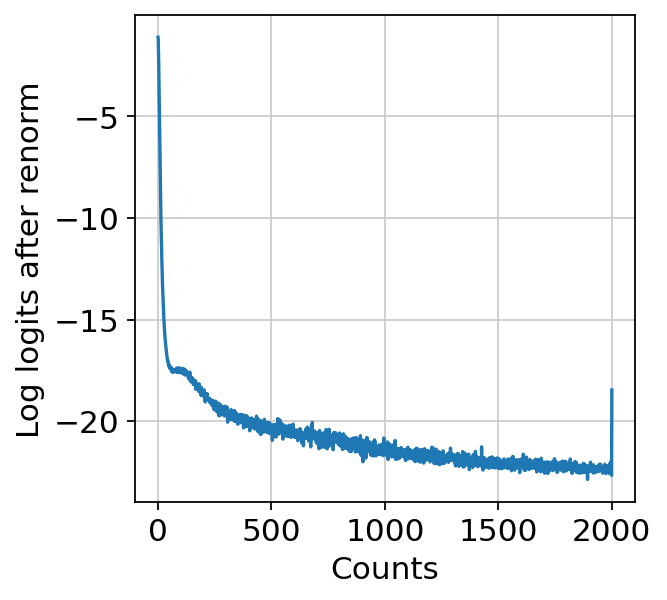

In [16]:
print(gene_logits_nqk.shape)
plt.plot(range(gene_logits_nqk.shape[2]), gene_logits_nqk[0][0])
plt.xlabel('Counts')
plt.ylabel('Log logits after renorm')

In [17]:
formatted = datetime.now().strftime("%Y_%m_%d_%H_%M")

filename = f'{formatted}_convert_to_{"_".join(target_assay.split())}'
clean_filename = re.sub(r'[^a-zA-Z0-9._-]', '', filename)

target_assay_out_dir = os.path.join(OUT_ADATA_DIR, clean_filename)
os.makedirs(target_assay_out_dir)

results_fp1 = os.path.join(target_assay_out_dir, f'original.h5ad')
results_fp2 = os.path.join(target_assay_out_dir, f'converted.h5ad')

sc.write(results_fp1, adata_fixed_genes_original)
sc.write(results_fp2, adata_fixed_genes_converted)